## Projekt grupowy "Klasyfikacja rodzajów szkła"

Zespół 17:
Maria Mierzejewska, 
Karol Cieślik, 
Jakub Matłacz

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
import warnings
warnings.filterwarnings('ignore')

## 1. Wczytanie danych oryginalnych

In [79]:
glass_org = pd.read_csv('glass.csv')
glass_org

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.00,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.00,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.00,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.00,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.00,0.0,1
...,...,...,...,...,...,...,...,...,...,...
209,1.51623,14.14,0.00,2.88,72.61,0.08,9.18,1.06,0.0,7
210,1.51685,14.92,0.00,1.99,73.06,0.00,8.40,1.59,0.0,7
211,1.52065,14.36,0.00,2.02,73.42,0.00,8.44,1.64,0.0,7
212,1.51651,14.38,0.00,1.94,73.61,0.00,8.48,1.57,0.0,7


Oznaczenia klas:<br>
-- 1 building windows float processed<br>
-- 2 building windows non float processed<br> 
-- 3 vehicle windows float processed<br>
-- 4 vehicle windows non float processed (none in this database)<br>
-- 5 containers<br>
-- 6 tableware<br>
-- 7 headlamps

## 2. Sprawdzenie braków danych

In [30]:
glass_org.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RI      214 non-null    float64
 1   Na      214 non-null    float64
 2   Mg      214 non-null    float64
 3   Al      214 non-null    float64
 4   Si      214 non-null    float64
 5   K       214 non-null    float64
 6   Ca      214 non-null    float64
 7   Ba      214 non-null    float64
 8   Fe      214 non-null    float64
 9   Type    214 non-null    int64  
dtypes: float64(9), int64(1)
memory usage: 16.8 KB


## 3. Wykresy pudełkowe i skrzypcowe

In [31]:
def pokaz_pudelka(glass):
    plt.figure(figsize=(10,50), dpi= 80)
    plt.subplot(10,1,1)
    sns.boxplot(data=glass.iloc[:,0:-1])
    atrybuty = "RI Na Mg Al Si K Ca Ba Fe".split()
    for i in range(2,11):
        plt.subplot(10,1,i)
        sns.boxplot(x="Type", y=atrybuty[i-2], data=glass)

In [32]:
def pokaz_skrzypce(glass):
    plt.figure(figsize=(10,50), dpi= 80)
    plt.subplot(10,1,1)
    sns.violinplot(data=glass.iloc[:,0:-1])
    atrybuty = "RI Na Mg Al Si K Ca Ba Fe".split()
    for i in range(2,11):
        plt.subplot(10,1,i)
        sns.violinplot(x="Type", y=atrybuty[i-2], data=glass)

Obejrzymy teraz wykresy pudełkowe i skrzypcowe oryginalnych danych:

In [ ]:
pokaz_pudelka(glass_org)

In [ ]:
pokaz_skrzypce(glass_org)

## 4. Macierz korelacji oraz macierz wykresów punktowych

Macierz korelacji Pearsona w celu ewentualnej eliminacji zbędnych atrybutów:

Widać, że cecha Ca jest mocno skorelowana z cechą RI jednak nie wystarczająco, aby pominąć jedną z nich.

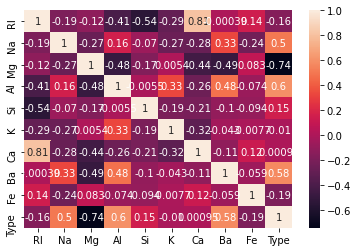

In [35]:
sns.heatmap(glass_org.corr(), annot = glass_org.corr())

Macierz wykresów punktowych w celu lepszej wizualizacji zbioru:

Widać, że cecha Ba może być dobrym wyznacznikiem przynależności obiektu do klasy 7. Wiele z histogramów przenika się w ogromnym stopniu.

In [ ]:
sns.pairplot(glass_org, kind="scatter", hue = "Type")

## 5. Oversampling oraz badanie dystrybucji klas  

In [33]:
def class_distr(glass):
    ile_ob_klas = []
    for i in range(1,8):
        ile_ob_klas.append(glass[glass.Type == i].shape[0])
    ile_ob_klas = pd.DataFrame(ile_ob_klas, index=range(1,8), columns=['ilość obiektów'])
    print(ile_ob_klas)
    ile_ob_klas.plot(kind='bar')

In [11]:
def podziel(df, proporcja):
    opis_ucz, opis_test, dec_ucz, dec_test = train_test_split(
        df.iloc[:,0:-1], df.iloc[:,-1], test_size=proporcja, random_state=3)
    return {"opis_ucz":opis_ucz, "opis_test":opis_test, "dec_ucz":dec_ucz, "dec_test":dec_test}

   ilość obiektów
1              70
2              76
3              17
4               0
5              13
6               9
7              29


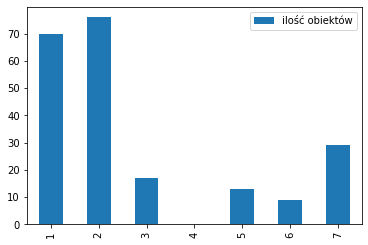

In [34]:
class_distr(glass_org)

Klasa 4 zostanie całkowicie pominięta w następujących rozważaniach i można ją traktować jako nieistniejącą. Z powodu braku jej próbek żaden obiekt nie będzie mógł zostać do niej przypisany.

Oryginalny zbiór jest niezbalansowany. Dzielimy go na część uczącą i testową. Pierwszą oversamplujemy (co jak widać na wykresie pozwoliło zbalansować zbiór uczący), a drugą zostawiamy i nie ruszamy tak, aby nie istniała część wspólna między zbiorem uczącym, a testowym (aby nasze wyniki nie były zakłamane).

In [40]:
glass_org_split = podziel(glass_org, 0.3)
x_learn = glass_org_split['opis_ucz']
y_learn = glass_org_split['dec_ucz']
x_test = glass_org_split['opis_test']
y_test = glass_org_split['dec_test']

In [41]:
sm = SMOTE()
x_learn_res, y_learn_res = sm.fit_resample(x_learn, y_learn)

Teraz obejrzyjmy wyniki podziału na część uczącą i testową:

   ilość obiektów
1              49
2              56
3              12
4               0
5               8
6               7
7              17


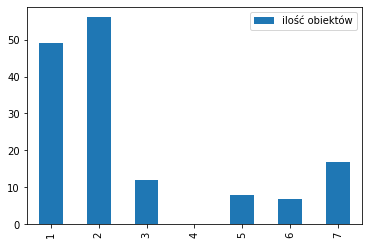

In [36]:
glass_learn = x_learn.copy()
glass_learn['Type'] = y_learn
class_distr(glass_learn)

   ilość obiektów
1              21
2              20
3               5
4               0
5               5
6               2
7              12


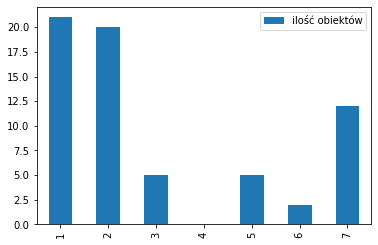

In [37]:
glass_test = x_test.copy()
glass_test['Type'] = y_test
class_distr(glass_test)

Dystrybucja klas w oversamplowanym zbiorzę uczącym:

   ilość obiektów
1              56
2              56
3              56
4               0
5              56
6              56
7              56


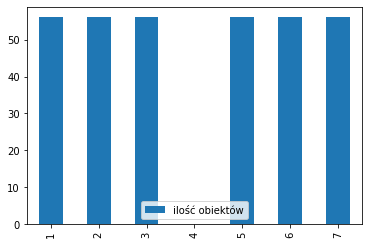

In [23]:
glass_learn_res = x_learn_res.copy()
glass_learn_res['Type'] = y_learn_res
class_distr(glass_learn_res)

## 6. Testowanie modeli

In [74]:
def weryfikuj(model):
    #pozwala sprawdzić z pomocą macierzy pomyłek jak działa dany model
    model.fit(x_learn_res, y_learn_res)
    
    wynik_ucz = model.predict(x_learn_res)
    wynik_test = model.predict(x_test)
    
    print("Macierz pomyłek dla zbioru uczącego")
    print(pd.crosstab(y_learn_res, wynik_ucz)) 
    wyn_ucz = model.score(x_learn_res, y_learn_res)
    print("Blad uczenia ", 1-wyn_ucz)
    
    print("\nMacierz pomyłek dla zbioru testowego")
    print(pd.crosstab(y_test, wynik_test)) 
    wyn_test = model.score(x_test, y_test)
    print("Blad testowania ", 1-wyn_test)
    
    print("\nPrecyzja i czułość\n", metrics.classification_report(y_test, wynik_test, digits=2))

In [75]:
def wykres_bledu(max_k):
    #tworzy wykres bledu dla algorytmu kNN by wybrać najlepsze k
    wyniki = []
    for i in range(1,max_k+1):
        model = KNeighborsClassifier(n_neighbors=i)
        model.fit(x_learn_res, y_learn_res)
        wyn_test = 1-model.score(x_test, y_test)
        wyniki.append(wyn_test)
    kwart = pd.DataFrame(wyniki, index=range(1,max_k+1))
    plt.figure(dpi=90)
    plt.plot(kwart,'bo-')
    plt.title('Wykres bledu')
    plt.xlabel('Liczba sasiadow')
    plt.ylabel('Prawdopodobienstwo bledu')

Szukanie najlepszego k dla algorytmu kNN. Jak widać poniżej najlepsze wyniki mamy dla k=2:

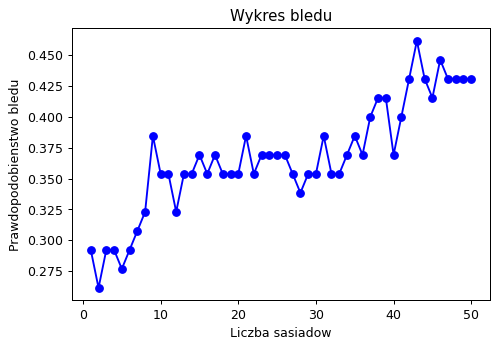

In [76]:
wykres_bledu(50)

> **KNeighborsClassifier**

Zaskakująco dobre wyniki tak prostego algorytmu uczenia leniwego. Być może za bardzo dopasowany do zbioru uczącego. Akceptowalny błąd zbioru testowego. Warto zauważyć, że błąd uczenia jest bardzo niski (ryzyko przetrenowania). Poza tym nie sprawdzam tylko błędu testowania gdyż zbiór testowy nie jest zbalansowany. Sprawdzam więc przede wszystkim precyzję i czułość.
<br>
Precyzja (precision) - true positives / all positives, zaklasyfikowane do klasy / wszystkie do niej zaklasyfikowane (także błędnie), większa = lepsza
<br>
Czułość (recall) - true positives / false negatives, ile ob. danej klasy zaklasyfikowano prawidłowo / wszystkie ob. danej klasy, większa = lepsza

In [77]:
model = KNeighborsClassifier(n_neighbors=2)
weryfikuj(model)

Macierz pomyłek dla zbioru uczącego
col_0   1   2   3   5   6   7
Type                         
1      56   0   0   0   0   0
2      10  46   0   0   0   0
3       3   0  53   0   0   0
5       0   0   0  56   0   0
6       0   0   0   0  56   0
7       0   0   0   0   0  56
Blad uczenia  0.038690476190476164

Macierz pomyłek dla zbioru testowego
col_0   1   2  3  5  6   7
Type                      
1      18   1  2  0  0   0
2       5  12  1  0  2   0
3       2   0  3  0  0   0
5       0   0  0  4  0   1
6       0   0  0  1  1   0
7       1   0  0  0  1  10
Blad testowania  0.2615384615384615

Precyzja i czułość
               precision    recall  f1-score   support

           1       0.69      0.86      0.77        21
           2       0.92      0.60      0.73        20
           3       0.50      0.60      0.55         5
           5       0.80      0.80      0.80         5
           6       0.25      0.50      0.33         2
           7       0.91      0.83      0.87        12

> **NearestCentroid**

In [50]:
model = NearestCentroid()
weryfikuj(model)

Macierz pomyłek dla zbioru uczącego
col_0   1  2   3   5   6   7
Type                        
1      27  8  21   0   0   0
2      17  6  25   7   1   0
3      27  0  29   0   0   0
5       0  0   0  56   0   0
6       0  0   0   1  54   1
7       0  0   2   3   6  45
Blad uczenia  0.35416666666666663

Macierz pomyłek dla zbioru testowego
col_0   1  2   3  5  6  7
Type                     
1      12  2   7  0  0  0
2       4  1  10  4  1  0
3       0  1   4  0  0  0
5       0  0   1  4  0  0
6       0  0   0  1  1  0
7       0  0   2  0  1  9
Blad testowania  0.523076923076923

Inne miary
               precision    recall  f1-score   support

           1       0.75      0.57      0.65        21
           2       0.25      0.05      0.08        20
           3       0.17      0.80      0.28         5
           5       0.44      0.80      0.57         5
           6       0.33      0.50      0.40         2
           7       1.00      0.75      0.86        12

    accuracy            

> **GaussianNB**

In [51]:
model = GaussianNB()
weryfikuj(model)

Macierz pomyłek dla zbioru uczącego
col_0   1  2   3   5   6   7
Type                        
1      26  1  28   0   1   0
2      27  7  17   5   0   0
3       4  1  50   0   1   0
5       0  0   0  56   0   0
6       0  0   0   0  56   0
7       0  0   0   1   0  55
Blad uczenia  0.25595238095238093

Macierz pomyłek dla zbioru testowego
col_0  1  2   3  5  6   7
Type                     
1      9  2  10  0  0   0
2      9  2   5  3  1   0
3      1  0   4  0  0   0
5      0  0   0  4  0   1
6      0  0   0  0  2   0
7      1  0   0  0  0  11
Blad testowania  0.5076923076923077

Inne miary
               precision    recall  f1-score   support

           1       0.45      0.43      0.44        21
           2       0.50      0.10      0.17        20
           3       0.21      0.80      0.33         5
           5       0.57      0.80      0.67         5
           6       0.67      1.00      0.80         2
           7       0.92      0.92      0.92        12

    accuracy           

> **DecisionTreeClassifier**

In [53]:
model = tree.DecisionTreeClassifier(max_depth=4)
weryfikuj(model)

Macierz pomyłek dla zbioru uczącego
col_0  1   2   3   5   6   7
Type                        
1      1   8  47   0   0   0
2      1  36  18   1   0   0
3      0   0  56   0   0   0
5      0   0   0  56   0   0
6      0   0   0   0  56   0
7      0   1   1   1   0  53
Blad uczenia  0.2321428571428571

Macierz pomyłek dla zbioru testowego
col_0  1   2   3  5  6   7
Type                      
1      0   5  15  0  0   1
2      1  11   5  1  1   1
3      0   1   4  0  0   0
5      0   1   0  3  0   1
6      0   0   0  0  2   0
7      0   0   1  0  0  11
Blad testowania  0.523076923076923

Inne miary
               precision    recall  f1-score   support

           1       0.00      0.00      0.00        21
           2       0.61      0.55      0.58        20
           3       0.16      0.80      0.27         5
           5       0.75      0.60      0.67         5
           6       0.67      1.00      0.80         2
           7       0.79      0.92      0.85        12

    accuracy     